In [67]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elabi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elabi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#  Analyse Exploratoire des Données (EDA)

##  Objectif de cette étape
Avant toute modélisation, il est essentiel de comprendre le dataset sur lequel nous allons travailler.  
L’EDA permet de :

- Vérifier la qualité des données
- Comprendre la structure du dataset (colonnes, types, taille…)
- Identifier les problèmes potentiels (doublons, valeurs manquantes…)
- Étudier la distribution de la variable cible (spam vs ham)
- Observer des patterns textuels utiles au traitement NLP

Cette étape oriente le choix des méthodes de prétraitement et des futurs modèles.

##  1. Présentation du Dataset
Dans cette partie, nous affichons :

- Le nombre total d’observations (emails)
- Le nombre de colonnes
- Les types de données
- Un aperçu des premières lignes

 Objectif : confirmer que le dataset est correctement chargé et structuré.


In [68]:
import pandas as pd

# Charger le dataset
df = pd.read_csv("../Data/raw/DataSet_Emails.csv")  

# Aperçu du dataset
print(" Aperçu des premières lignes :")
display(df.head())


 Aperçu des premières lignes :


,Unnamed: 0,message_id,text,label,label_text,subject,message,date
0,0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


In [69]:
# Dimensions du dataset
print("\n Dimensions du dataset :")
print(df.shape)


 Dimensions du dataset :
(31716, 8)


In [70]:
# Types de données
print("\n Types de colonnes :")
print(df.dtypes)


 Types de colonnes :
Unnamed: 0     int64
message_id     int64
text          object
label          int64
label_text    object
subject       object
message       object
date          object
dtype: object


In [71]:
df.describe()

,Unnamed: 0,message_id,label
count,31716.000000,31716.000000,31716.000000
mean,15857.500000,16854.187539,0.509617
std,9155.764905,9734.616392,0.499915
min,0.000000,0.000000,0.000000
25%,7928.750000,8429.750000,0.000000
50%,15857.500000,16850.500000,1.000000
75%,23786.250000,25295.250000,1.000000
max,31715.000000,33715.000000,1.000000


 **Interprétation :**

- Le dataset contient **31 716 messages textuels**
- La variable `label` est binaire :
  - `0` = ham (non-spam)
  - `1` = spam
- La proportion de spam ≈ **51%**, donc dataset équilibré
- `Unnamed: 0` semble être un index inutile → candidat à suppression
- Les colonnes `text`, `message`, `subject` contiennent du texte utile pour NLP
- La colonne `date` devra probablement être convertie en format datetime

 Le dataset est propre, structuré et exploitable pour une tâche de classification NLP.


##  2. Valeurs Manquantes et Doublons
Identification :
- des lignes contenant du texte vide
- des emails dupliqués

 Objectif : garantir la qualité des données.

In [72]:
# Nombre total de valeurs manquantes par colonne
df.isna().sum()


Unnamed: 0      0
message_id      0
text           51
label           0
label_text      0
subject       274
message       345
date            0
dtype: int64

In [73]:
# Doublons basés sur le texte des emails
df['text'].duplicated().sum()


np.int64(2904)

In [74]:
# Suppression des doublons exacts sur le texte
df = df.drop_duplicates(subset='text')

df.shape


(28812, 8)

In [75]:
print("Valeurs manquantes restantes :")
print(df.isna().sum())

print("\nTaille finale du dataset :", df.shape)


Valeurs manquantes restantes :
Unnamed: 0      0
message_id      0
text            1
label           0
label_text      0
subject       190
message       241
date            0
dtype: int64

Taille finale du dataset : (28812, 8)


##  3. Analyse de la variable cible : spam vs ham

###  Objectif
Avant d'entraîner un modèle de classification, il est essentiel de vérifier l’équilibre des classes :

- Un dataset équilibré permet un apprentissage plus stable.
- Un déséquilibre marqué peut nécessiter des techniques comme **oversampling**, **undersampling**, ou **SMOTE**.

Nous allons donc :

1. Compter le nombre de messages `spam` et `ham`.
2. Visualiser la distribution avec un graphique.
3. Calculer le pourcentage de chaque classe.


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comptage des classes
label_counts = df['label'].value_counts()
print("Nombre d'emails par classe :")
print(label_counts)

# Pourcentage des classes
label_percent = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage des classes :")
print(label_percent.round(2))


Nombre d'emails par classe :
label
0    14982
1    13830
Name: count, dtype: int64

Pourcentage des classes :
label
0    52.0
1    48.0
Name: proportion, dtype: float64


C:\Users\elabi\AppData\Local\Temp\ipykernel_15156\4012210385.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#2ecc71','#e74c3c'])


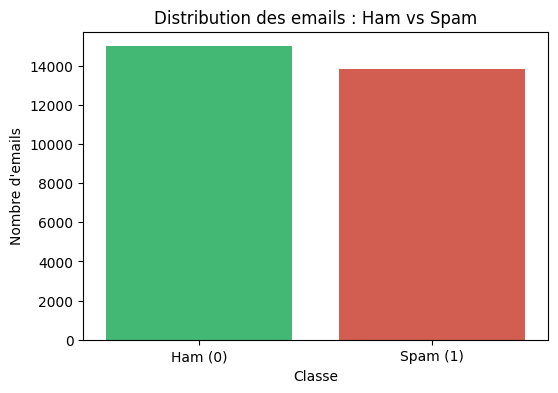

In [77]:
# Visualisation graphique
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette=['#2ecc71','#e74c3c'])
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.title("Distribution des emails : Ham vs Spam")
plt.xlabel("Classe")
plt.ylabel("Nombre d'emails")
plt.show()


###  Interprétation

- Le dataset contient **à peu près autant de ham que de spam** (52% ham / 48% spam).  
- La distribution est **quasi équilibrée**, donc aucune correction immédiate n’est nécessaire pour l’entraînement.  
- Cette observation valide que notre dataset est **adapté à un modèle de classification supervisé**.



## 4. Visualisation des mots fréquents : WordClouds

### Objectif
Les **WordClouds** permettent d’identifier visuellement les mots les plus fréquents dans les emails, selon leur catégorie (spam ou ham).  

- Permet de **comprendre rapidement les patterns textuels**.
- Aide à **orienter le prétraitement** (par exemple suppression de mots peu informatifs ou très fréquents).
- Permet d’identifier des mots caractéristiques du spam (ex : "viagra", "offer", "free") ou du ham.

---

### Méthodologie
1. Séparer les emails en deux groupes : **spam** et **ham**.
2. Concaténer le texte de chaque groupe.
3. Générer un WordCloud pour chaque catégorie.
4. Visualiser les résultats.


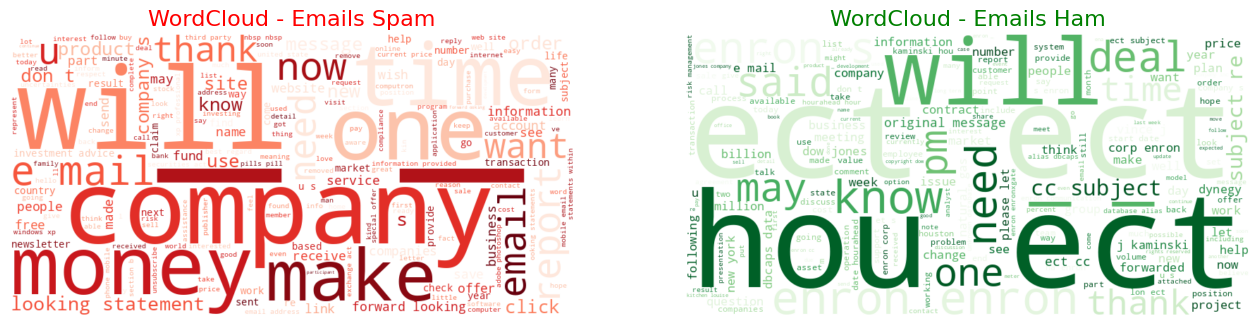

In [78]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convertir en str et supprimer les NaN
spam_text = " ".join(df[df['label'] == 1]['text'].dropna().astype(str))
ham_text  = " ".join(df[df['label'] == 0]['text'].dropna().astype(str))

# Générer le WordCloud pour les emails spam
spam_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)

# Générer le WordCloud pour les emails ham
ham_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(ham_text)

# Affichage des WordClouds
plt.figure(figsize=(16,8))

# Spam
plt.subplot(1,2,1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Emails Spam", fontsize=16, color='red')

# Ham
plt.subplot(1,2,2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Emails Ham", fontsize=16, color='green')

plt.show()


##  Interprétation des WordClouds

L’image ci-dessus montre les **mots les plus fréquents** dans les emails **spam** (à gauche, en rouge) et **ham** (à droite, en vert) :

###  Emails Spam
- Les mots dominants sont : `company`, `make`, `time`, `one`, `mail`, `now`, `offer`.  
- Ces termes sont liés à la **publicité**, aux **offres promotionnelles** et aux **actions commerciales rapides**, caractéristiques des emails indésirables.
- On remarque aussi des mots comme `click` ou `site`, typiques des messages contenant des liens ou des incitations à l’action.

###  Emails Ham (légitimes)
- Les mots fréquents sont : `ect`, `subject`, `will`, `project`, `need`, `know`, `pm`, `enron`, `email`.  
- Ces termes reflètent un **contenu professionnel ou informatif**, souvent lié aux échanges internes ou aux communications d’entreprise.
- Les mots sont plus neutres et contextuels, ce qui les distingue des emails spam.

###  Conclusion
- Les WordClouds permettent d’**identifier visuellement les différences lexicales** entre spam et ham.
- Ces informations sont utiles pour :
  - Orienter le **prétraitement du texte** (stopwords, nettoyage ponctuation, normalisation)
  - Identifier des mots caractéristiques pour améliorer la **précision du modèle de classification NLP**.


In [79]:
print(df.columns)

Index(['Unnamed: 0', 'message_id', 'text', 'label', 'label_text', 'subject',
       'message', 'date'],
      dtype='object')


In [80]:
df = df[['text', 'label', 'label_text']]

In [81]:
df.head(5)

,text,label,label_text
0,any software just for 15 $ - 99 $ understandin...,1,spam
1,perspective on ferc regulatory action client c...,0,ham
2,wanted to try ci 4 lis but thought it was way ...,1,spam
3,"enron / hpl actuals for december 11 , 2000 tec...",0,ham
4,looking for cheap high - quality software ? ro...,1,spam


In [82]:
print("Valeurs manquantes restantes :")
print(df.isna().sum())

print("\nTaille finale du dataset :", df.shape)


Valeurs manquantes restantes :
text          1
label         0
label_text    0
dtype: int64

Taille finale du dataset : (28812, 3)


In [83]:
# Supprimer la ligne contenant une valeur manquante dans "text"
df = df.dropna(subset=["text"])

print("Valeurs manquantes restantes :")
print(df.isna().sum())

print("\nTaille finale du dataset :", df.shape)


Valeurs manquantes restantes :
text          0
label         0
label_text    0
dtype: int64

Taille finale du dataset : (28811, 3)


In [84]:
df.to_csv("../Data/cleaned/cleaned_data.csv", index=False, encoding="utf-8")
